# Путинцев Данил P3307 Вариант четный. Метод k-ближайших соседей. Лабораторная работа №4

Деревья решений — алгоритм машинного обучения, строящий иерархическую структуру решающих правил. Алгоритм C4.5 использует нормированный прирост информации (Gain Ratio) для выбора оптимальных признаков. В данной реализации добавлен случайный отбор √n признаков в каждом узле для повышения устойчивости модели.

In [14]:
import numpy as np
import math
import csv

class Node:
    """Узел дерева решений"""
    def __init__(self, feature=None, value=None, results=None, children=None):
        self.feature = feature      # Индекс признака для разделения
        self.value = value          # Значение признака
        self.results = results      # Распределение классов (для листьев)
        self.children = children    # Список дочерних узлов

class DecisionTree:
    """Класс дерева решений с случайным выбором признаков"""
    
    def __init__(self, max_depth=10, min_samples_split=2):
        """
        Инициализация дерева решений
        
        Parameters:
        max_depth - максимальная глубина дерева
        min_samples_split - минимальное количество samples для разделения
        """
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None
        self.feature_names = None

    def fit(self, X, y, feature_names=None):
        """
        Построение дерева решений на обучающих данных
        
        Parameters:
        X - матрица признаков
        y - вектор меток классов
        feature_names - названия признаков
        """
        self.feature_names = feature_names
        self.root = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        """
        Рекурсивное построение дерева решений
        
        Parameters:
        X - матрица признаков
        y - вектор меток классов
        depth - текущая глубина дерева
        
        Returns:
        Node - узел дерева
        """
        # Вычисляем распределение классов для текущего узла
        node_distribution = self._calculate_class_distribution(y)
        
        # Условия остановки рекурсии
        if len(y) < self.min_samples_split or depth >= self.max_depth:
            return Node(results=node_distribution)
        
        # Если все элементы одного класса
        if len(np.unique(y)) == 1:
            return Node(results=node_distribution)

        # Случайный выбор √n признаков
        n_features = X.shape[1]
        selected_features = np.random.choice(
            n_features, 
            size=max(1, int(math.sqrt(n_features))), 
            replace=False
        )
        
        # Поиск лучшего признака для разделения
        best_gain = 0
        best_feature = None
        best_splits = None

        for feature in selected_features:
            gain, splits = self._best_split(X, y, feature)
            if gain > best_gain:
                best_gain = gain
                best_feature = feature
                best_splits = splits

        # Если не удалось найти хорошее разделение
        if best_gain == 0:
            return Node(results=node_distribution)

        # Рекурсивное построение дочерних узлов
        children = []
        for value, (X_sub, y_sub) in best_splits.items():
            if len(y_sub) == 0:
                continue
            child = self._build_tree(X_sub, y_sub, depth + 1)
            children.append((value, child))
        
        # Если не создано ни одного дочернего узла, возвращаем лист
        if not children:
            return Node(results=node_distribution)
        
        # Создаем внутренний узел с распределением
        node = Node(feature=best_feature, children=children)
        node.results = node_distribution  # Сохраняем распределение для надежности
        return node

    def _best_split(self, X, y, feature):
        """
        Нахождение лучшего разделения для заданного признака
        
        Parameters:
        X - матрица признаков
        y - вектор меток классов
        feature - индекс признака для анализа
        
        Returns:
        gain_ratio - значение Gain Ratio
        splits - словарь с разделенными данными
        """
        values = np.unique(X[:, feature])
        if len(values) < 2:
            return 0, {}
        
        # Расчет энтропии до разделения
        base_entropy = self._calculate_entropy(y)
        
        # Создание разделений
        splits = {}
        for value in values:
            mask = X[:, feature] == value
            splits[value] = (X[mask], y[mask])

        # Расчет прироста информации и информации разделения
        info_gain = base_entropy
        split_info = 0
        
        for (X_sub, y_sub) in splits.values():
            p = len(y_sub) / len(y)
            info_gain -= p * self._calculate_entropy(y_sub)
            if p > 0:
                split_info -= p * math.log2(p)

        # Gain Ratio
        if split_info == 0:
            return 0, {}
            
        gain_ratio = info_gain / split_info
        return gain_ratio, splits

    def _calculate_entropy(self, y):
        """
        Расчет энтропии множества меток
        
        Parameters:
        y - вектор меток классов
        
        Returns:
        entropy - значение энтропии
        """
        if len(y) == 0:
            return 0
        counts = np.bincount(y)
        probabilities = counts / len(y)
        entropy = 0
        for p in probabilities:
            if p > 0:
                entropy -= p * math.log2(p)
        return entropy

    def _calculate_class_distribution(self, y):
        """
        Расчет распределения классов в множестве
        
        Parameters:
        y - вектор меток классов
        
        Returns:
        distribution - словарь с распределением классов
        """
        class_counts = {}
        for cls in y:
            class_counts[cls] = class_counts.get(cls, 0) + 1
        
        total = len(y)
        return {cls: count / total for cls, count in class_counts.items()}

    def predict_proba(self, X):
        """
        Предсказание вероятностей классов
        
        Parameters:
        X - матрица признаков
        
        Returns:
        probas - вектор вероятностей положительного класса
        """
        return np.array([self._predict_single(x) for x in X])

    def _predict_single(self, x):
        """
        Предсказание для одного примера
        
        Parameters:
        x - вектор признаков одного примера
        
        Returns:
        probability - вероятность положительного класса
        """
        node = self.root
        while node is not None and node.children is not None:
            value = x[node.feature]
            found_child = False
            for child_value, child_node in node.children:
                if child_value == value:
                    node = child_node
                    found_child = True
                    break
            if not found_child:
                break
        
        # Безопасное получение вероятности
        if node is not None and node.results is not None:
            return node.results.get(1, 0.0)
        else:
            return 0.0  # Возвращаем 0 если что-то пошло не так

    def predict(self, X, threshold=0.5):
        """
        Предсказание классов
        
        Parameters:
        X - матрица признаков
        threshold - порог для бинаризации вероятностей
        
        Returns:
        predictions - вектор предсказанных классов
        """
        probas = self.predict_proba(X)
        return (probas >= threshold).astype(int)


## Загрузка и предобработка данных

In [15]:
import csv

def load_data_from_csv(filename):
    """
    Загрузка данных из CSV файла с использованием модуля csv
    
    Parameters:
    filename - путь к CSV файлу
    
    Returns:
    X - матрица признаков
    y - вектор меток классов
    feature_names - список названий признаков
    """
    data = []
    labels = []
    
    with open(filename, 'r', newline='', encoding='utf-8') as f:
        reader = csv.reader(f)
        header = next(reader)  # Чтение заголовка
        feature_names = header[1:]
        
        for row in reader:
            if row:  # Пропуск пустых строк
                label = 1 if row[0] == 'e' else 0
                features = row[1:]
                labels.append(label)
                data.append(features)
    
    return np.array(data), np.array(labels), feature_names

def encode_features(X):
    """
    Кодирование категориальных признаков в числовые
    
    Parameters:
    X - матрица категориальных признаков
    
    Returns:
    encoded_X - матрица закодированных признаков
    feature_encodings - список словарей кодирования для каждого признака
    """
    encoded_X = np.zeros(X.shape, dtype=int)
    feature_encodings = []
    
    for i in range(X.shape[1]):
        unique_values = np.unique(X[:, i])
        encoding = {val: idx for idx, val in enumerate(unique_values)}
        feature_encodings.append(encoding)
        for j in range(X.shape[0]):
            encoded_X[j, i] = encoding[X[j, i]]
    
    return encoded_X, feature_encodings

# Загрузка данных
X, y, feature_names = load_data_from_csv('/home/danil/github_repos/ITMO/course3/AI/lab5/test.csv')
X_encoded, feature_encodings = encode_features(X)

print(f"Данные: {X.shape[0]} образцов, {X.shape[1]} признаков")
print(f"Распределение классов: {np.sum(y)} положительных, {len(y) - np.sum(y)} отрицательных")

Данные: 8124 образцов, 22 признаков
Распределение классов: 4208 положительных, 3916 отрицательных


## Разделение данных и обучение модели

In [16]:
split_idx = int(0.7 * len(X))
X_train, X_test = X_encoded[:split_idx], X_encoded[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Обучающая выборка: {X_train.shape[0]} образцов")
print(f"Тестовая выборка: {X_test.shape[0]} образцов")

# Обучение модели
tree = DecisionTree(max_depth=4, min_samples_split=2)
tree.fit(X_train, y_train, feature_names=feature_names)
print("Модель успешно обучена")

Обучающая выборка: 5686 образцов
Тестовая выборка: 2438 образцов
Модель успешно обучена


## Метрики оценки качества

def accuracy_score(y_true, y_pred):
    """
    Расчет точности (Accuracy)
    
    Parameters:
    y_true - истинные метки классов
    y_pred - предсказанные метки классов
    
    Returns:
    accuracy - значение точности
    """
    return np.mean(y_true == y_pred)

def precision_score(y_true, y_pred):
    """
    Расчет точности предсказания (Precision)
    
    Parameters:
    y_true - истинные метки классов
    y_pred - предсказанные метки классов
    
    Returns:
    precision - значение точности предсказания
    """
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    return tp / (tp + fp) if (tp + fp) > 0 else 0

def recall_score(y_true, y_pred):
    """
    Расчет полноты (Recall)
    
    Parameters:
    y_true - истинные метки классов
    y_pred - предсказанные метки классов
    
    Returns:
    recall - значение полноты
    """
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp / (tp + fn) if (tp + fn) > 0 else 0

# Предсказания и оценка
y_pred = tree.predict(X_test)
y_proba = tree.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Метрики классификации:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

# Матрица ошибок
tp = np.sum((y_test == 1) & (y_pred == 1))
fp = np.sum((y_test == 0) & (y_pred == 1))
fn = np.sum((y_test == 1) & (y_pred == 0))
tn = np.sum((y_test == 0) & (y_pred == 0))

print(f"\nМатрица ошибок:")
print(f"TP: {tp}, FP: {fp}")
print(f"FN: {fn}, TN: {tn}")

## Построение кривых качества

In [23]:
def roc_curve(y_true, y_proba):
    """
    Построение ROC-кривой
    
    Parameters:
    y_true - истинные метки классов
    y_proba - предсказанные вероятности положительного класса
    
    Returns:
    fpr - значения False Positive Rate
    tpr - значения True Positive Rate
    thresholds - пороги классификации
    """
    thresholds = np.sort(np.unique(y_proba))[::-1]
    tpr, fpr = [], []
    
    for thresh in thresholds:
        y_pred = (y_proba >= thresh).astype(int)
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        tn = np.sum((y_true == 0) & (y_pred == 0))
        
        tpr_val = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr_val = fp / (fp + tn) if (fp + tn) > 0 else 0
        
        tpr.append(tpr_val)
        fpr.append(fpr_val)
    
    return fpr, tpr, thresholds

def pr_curve(y_true, y_proba):
    """
    Построение Precision-Recall кривой
    
    Parameters:
    y_true - истинные метки классов
    y_proba - предсказанные вероятности положительного класса
    
    Returns:
    recall_vals - значения Recall
    precision_vals - значения Precision
    thresholds - пороги классификации
    """
    thresholds = np.sort(np.unique(y_proba))[::-1]
    precision_vals, recall_vals = [], []
    
    for thresh in thresholds:
        y_pred = (y_proba >= thresh).astype(int)
        precision_vals.append(precision_score(y_true, y_pred))
        recall_vals.append(recall_score(y_true, y_pred))
    
    return recall_vals, precision_vals, thresholds

def auc(x, y):
    """
    Расчет площади под кривой методом трапеций
    
    Parameters:
    x - значения по оси X
    y - значения по оси Y
    
    Returns:
    area - площадь под кривой
    """
    sorted_indices = np.argsort(x)
    x_sorted = np.array(x)[sorted_indices]
    y_sorted = np.array(y)[sorted_indices]
    
    area = 0
    for i in range(1, len(x_sorted)):
        dx = x_sorted[i] - x_sorted[i-1]
        avg_y = (y_sorted[i] + y_sorted[i-1]) / 2
        area += dx * avg_y
    
    return area

# Расчет метрик качества
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

recall_curve, precision_curve, _ = pr_curve(y_test, y_proba)
pr_auc = auc(recall_curve, precision_curve)

print("Качество модели:")
print(f"AUC-ROC: {roc_auc:.4f}")
print(f"AUC-PR:  {pr_auc:.4f}")

Качество модели:
AUC-ROC: 0.8326
AUC-PR:  0.3296


## Визуализация результатов

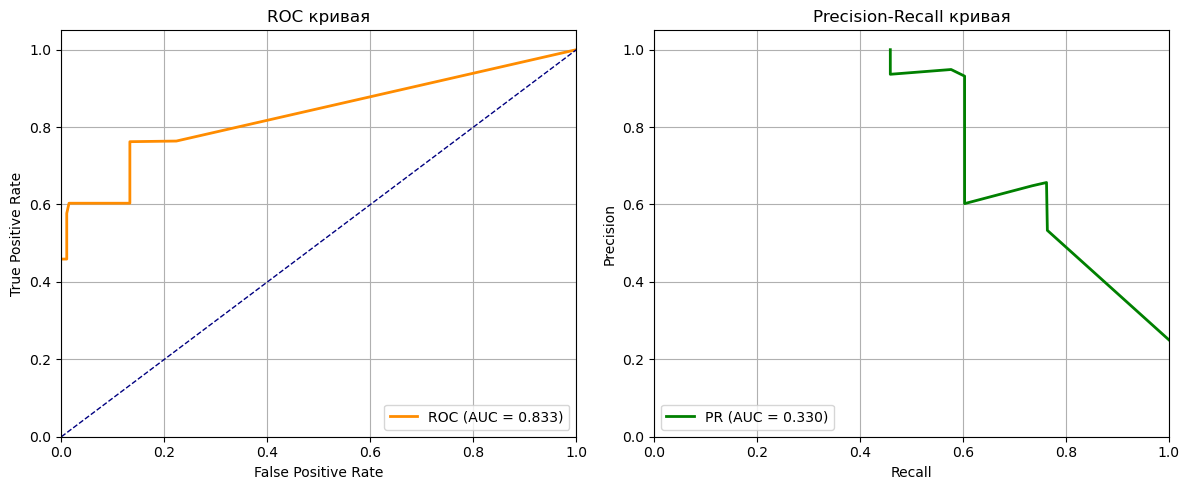

In [24]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# ROC кривая
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC кривая')
ax1.legend(loc="lower right")
ax1.grid(True)

# PR кривая
ax2.plot(recall_curve, precision_curve, color='green', lw=2, label=f'PR (AUC = {pr_auc:.3f})')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall кривая')
ax2.legend(loc="lower left")
ax2.grid(True)

plt.tight_layout()
plt.show()

## Анализ результатов

In [25]:
print("Анализ результатов:")
print(f"Качество модели: {'отличное' if roc_auc > 0.95 else 'хорошее' if roc_auc > 0.85 else 'удовлетворительное'}")
print(f"Баланс Precision-Recall: {'сбалансированный' if abs(precision - recall) < 0.1 else 'смещенный к точности' if precision > recall else 'смещенный к полноте'}")

if fp == 0:
    print("Ложные срабатывания отсутствуют")
else:
    print(f"Обнаружены ложные срабатывания: {fp}")

Анализ результатов:
Качество модели: удовлетворительное
Баланс Precision-Recall: сбалансированный
Обнаружены ложные срабатывания: 243


In [26]:
print("Примеры предсказаний:")

for i in range(min(3, len(X_test))):
    sample_features = X_test[i]
    true_label = y_test[i]
    prediction = tree.predict(np.array([sample_features]))[0]
    probability = tree.predict_proba(np.array([sample_features]))[0]
    
    true_class = "съедобный" if true_label == 1 else "ядовитый"
    pred_class = "съедобный" if prediction == 1 else "ядовитый"
    
    print(f"Образец {i+1}: истинный - {true_class}, предсказанный - {pred_class}, вероятность - {probability:.4f}")

Примеры предсказаний:
Образец 1: истинный - съедобный, предсказанный - съедобный, вероятность - 1.0000
Образец 2: истинный - съедобный, предсказанный - съедобный, вероятность - 1.0000
Образец 3: истинный - ядовитый, предсказанный - съедобный, вероятность - 0.9169
